In [1]:
# Copyright (c) 2015, Cordoba Astronomical Observatory.  All rights reserved.
#                    Unauthorized reproduction prohibited. 
# NAME:
#        aligo-vs-glade
# PURPOSE:
#        "Toritos Scheduler White catalog loader
#
# CATEGORY:
#	     Program.
#
# COMPILING SEQUENCE:
# 	     ipython notebook
#
# INPUTS:
#
#
# MODIFICATION HISTORY:
# 	Written by:	Mariano Dominguez, July 2015
#   from previuos version using White Catalog January 2014.
#   Any inquirities send an e-mail to mardom@oac.uncor.edu
#

# Modified by Bruno Sanchez, October 2015

In [72]:
# Global paths and constants
data_path = '.'
# Load useful packages
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

#import seaborn
%matplotlib inline

In [73]:
#graphic output directory.
plots = './plots'
if not os.path.isdir(plots):
    os.mkdir(plots)

In [74]:
import time
print (time.strftime("%d/%m/%Y"))
print (time.strftime("%H:%M:%S"))

macon_date=time.strftime("%Y/%m/%d %H:%M:%S")

print 

12/11/2015
18:33:38



In [75]:
import ephem
macon = ephem.Observer()
macon.lat = '-24.623'
macon.lon = '-67.328'
macon.elevation = 4600

# extracting the correct values. WEIRD
print float(ephem.degrees(macon.lon*180./m.pi)), float(ephem.degrees(macon.lat*180./m.pi))

-67.328 -24.623


In [76]:
sun = ephem.Sun()
sun.compute(macon)
print sun.a_ra, sun.a_dec
sun_coords = SkyCoord(str(sun.a_ra), str(sun.a_dec), unit=(u.hourangle, u.deg))

print "Sun coordinates are = {}".format(sun_coords.to_string('hmsdms'))

moon = ephem.Moon()
moon.compute(macon)
moon_coords = SkyCoord(str(moon.a_ra), str(moon.a_dec), unit=(u.hourangle, u.deg))

print "Moon coordinates are = {}".format(moon_coords.to_string('hmsdms'))

15:10:03.66 -17:43:42.6
Sun coordinates are = 15h10m03.66s -17d43m42.6s
Moon coordinates are = 16h07m41.67s -16d16m36.9s


This part intends to calculate the rising and setting of the sun at the given date and at Macon.
Since the big errors and differences for the actual setting and rising times of the sun here, we don't trust it at all. Anyway it is not used for any kind of calculation.

In [77]:
sunrise, sunset = macon.next_rising(sun), macon.next_setting(sun)

print "The time of sunset is {}, \nand the time of sunrise is {}".format(sunset, sunrise)

The time of sunset is 2015/11/12 22:51:29, 
and the time of sunrise is 2015/11/13 09:35:17


In [78]:
# at sunset 
alpha_zenith_sunset = sun_coords.ra + 75.*u.deg
alpha_observable_min = alpha_zenith_sunset - 40.*u.deg

In [79]:
# at sunrise
alpha_zenith_sunrise = sun_coords.ra - 105.*u.deg
alpha_observable_max = alpha_zenith_sunset + 40.*u.deg

In [80]:
print alpha_observable_min.hour, alpha_observable_max.hour

17.5010166667 22.83435


In [81]:
white_cat='./GWGCCatalog.txt'

white_table = ascii.read(white_cat, delimiter=' ', format='commented_header')#, data_start=2
white_table

PGC,Name,RA,Dec,Type,App_Mag,Maj_Diam_a,err_Maj_Diam,Min_Diam_b,err_Min_Diam,b/a,err_b/a,PA,Abs_Mag,Dist,err_Dist,err_App_Mag,err_Abs_Mag
float64,string224,float64,float64,string32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2.0,UGC12889,0.00047,47.2745,3.1,13.31,1.546,0.498,1.314,nan,0.85,0.1,nan,-21.05,72.458,10.869,0.61,0.61
4.0,PGC000004,0.00096,23.08764,5.0,15.39,0.851,0.078,0.186,nan,0.219,0.015,nan,-18.68,63.264,13.918,0.39,0.4
6.0,PGC000006,0.00058,15.88165,-1.0,15.23,0.457,0.169,0.324,nan,0.708,0.082,nan,-19.46,84.181,18.52,0.34,0.35
7.0,PGC000007,0.00122,-0.08326,-3.2,15.54,0.575,0.093,0.467,nan,0.813,0.056,nan,-19.46,97.347,21.416,0.33,0.34
10.0,PGC000010,0.00217,-0.04057,-3.2,15.56,0.562,0.078,0.446,nan,0.794,0.037,nan,-19.46,98.25,21.615,0.29,0.31
12.0,PGC000012,0.0024,-6.3739,1.1,14.05,1.045,0.336,0.199,nan,0.19,0.022,nan,-20.79,92.153,13.823,0.36,0.37
13.0,PGC000013,0.0037,33.1342,NaN,15.41,0.675,0.217,0.587,nan,0.87,0.102,nan,-18.94,72.722,10.908,0.4,0.41
16.0,PGC000016,0.00314,-5.15871,1.2,14.6,0.63,0.203,0.328,nan,0.52,0.061,nan,-19.93,79.278,11.892,0.29,0.3
18.0,PGC000018,0.0036,46.96508,NaN,14.25,0.869,0.28,0.791,nan,0.91,0.107,nan,-20.25,77.306,11.596,0.31,0.32


In [82]:
dist_lim = 80.
near = white_table['Dist'] < dist_lim      # Distance cut
visible = white_table['App_Mag']< 18.5     # Apparent Magnitude cut
bright = white_table['Abs_Mag']< -18.      # Absolute Magnitude cut
lim_dec = white_table['Dec']< 30.          # Declination cut
alfa_min = white_table['RA'] >  float(alpha_observable_min.hour)       # Alpha cut 
alfa_max = white_table['RA'] <= float(alpha_observable_max.hour)

/home/bruno/.virtualenvs/alertreport/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/bruno/.virtualenvs/alertreport/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


In [83]:
if alpha_observable_max.hour > alpha_observable_min.hour:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min & alfa_max)]
else:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min | alfa_max)]

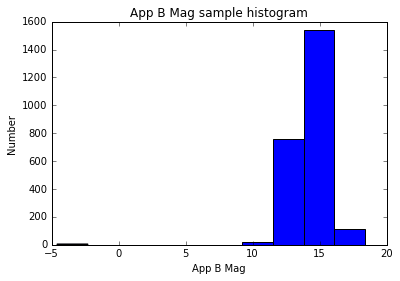

In [84]:
plt.hist(sample['App_Mag'])
plt.xlabel('App B Mag')
plt.ylabel('Number')
plt.title('App B Mag sample histogram')

plt.savefig(os.path.join(plots, 'appmag_sample_histogram.png'), dpi=300)

plt.show()

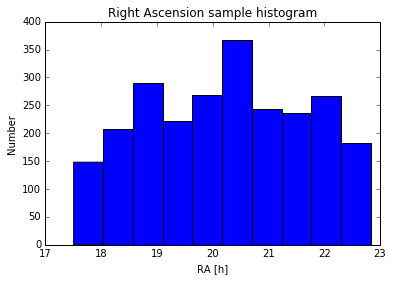

In [85]:
plt.hist(sample['RA'])
plt.xlabel('RA [h]')
plt.ylabel('Number')
plt.title('Right Ascension sample histogram')

plt.savefig(os.path.join(plots, 'RA_sample_histogram.png'), dpi=300)

plt.show()

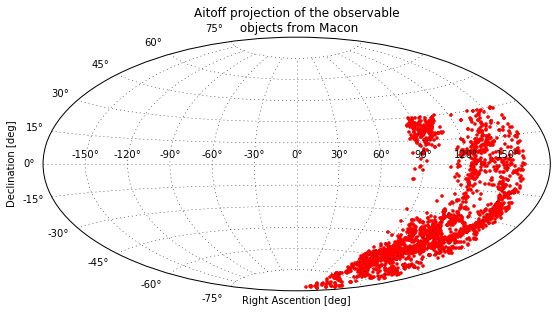

In [86]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="aitoff")
deg2rad=np.pi/180.

xg = (sample['RA']*15. - 180)*deg2rad
yg = sample['Dec']*deg2rad

# we should avoid the galactic plane
plt.plot(xg,yg, "r.")
plt.grid(True)
plt.title("Aitoff projection of the observable\n objects from Macon")
plt.xlabel("Right Ascention [deg]")
plt.ylabel("Declination [deg]")
plt.savefig(os.path.join(plots, 'radec_aitoff_sample.png'), dpi=300)
plt.show()

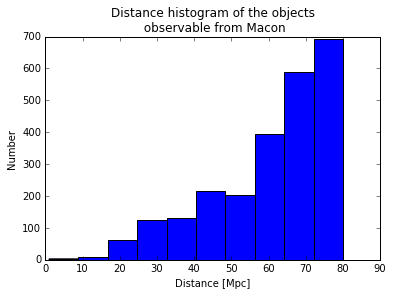

In [87]:
plt.hist(sample['Dist'], range=[1,dist_lim])
plt.title('Distance histogram of the objects\n observable from Macon')

plt.xlabel('Distance [Mpc]')
plt.ylabel('Number')

plt.savefig(os.path.join(plots, 'distance_histogram_sample.png'), dpi=300)

plt.show()

In [88]:
import healpy as hp

In [89]:
aligo_alert_data_file=os.path.join(data_path,"skymap.fits")
NSIDE=512 #2048
aligo_banana = hp.read_map(aligo_alert_data_file)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


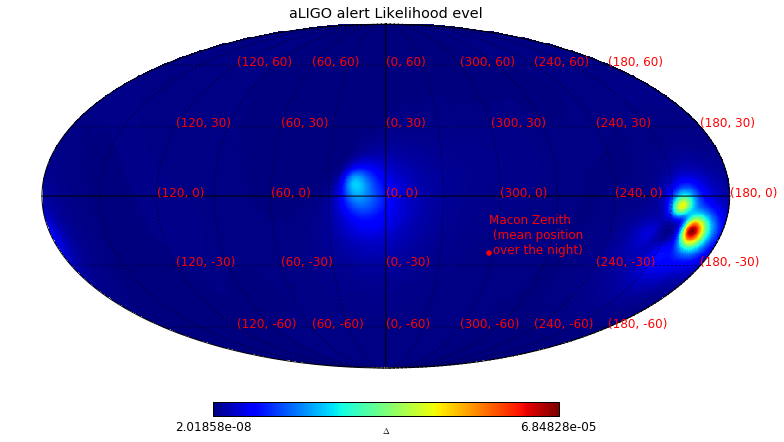

In [101]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
hp.mollview(aligo_banana, title='aLIGO alert Likelihood evel', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)

mean_zenith_ra = 15.*(alpha_observable_max.hour+alpha_observable_min.hour)/2.
zenith_dec = float(ephem.degrees(macon.lat*180./m.pi))

hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")
for ra in range(0,360,60):
    for dec in range(-60,90,30):
        if not (ra == 300 and dec == -30):
                hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)
plt.show()

50.5891087121 129.410891288 -39.4108912879 39.4108912879
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 4 deg 0.00'.


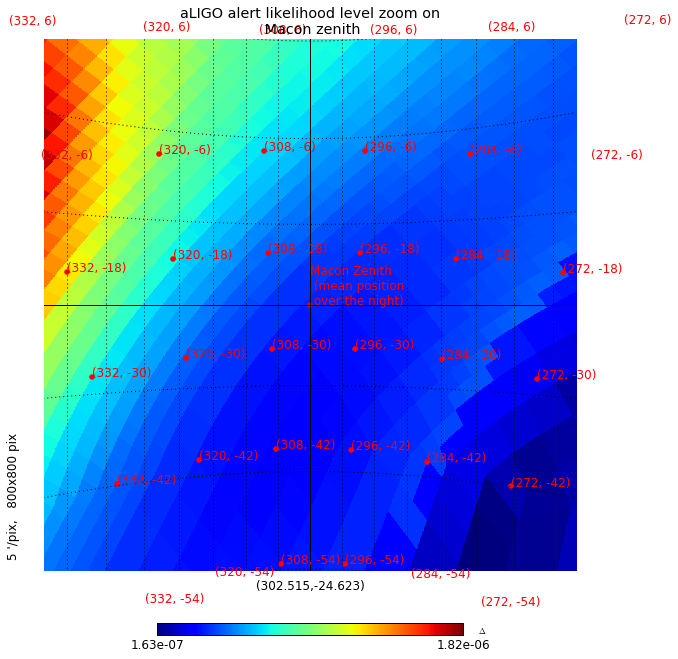

In [102]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
rot=[mean_zenith_ra, zenith_dec]
hp.gnomview(aligo_banana, rot=rot, title='aLIGO alert likelihood level zoom on\n Macon zenith', flip="astro",
            unit='$\Delta$', fig=2, xsize=800, reso=5)
fig.axes[1].texts[0].set_fontsize(8)

hp.projscatter(rot, lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(int(mean_zenith_ra)-30, int(mean_zenith_ra)+42, 12):
    for dec in range(int(zenith_dec)-30, int(zenith_dec)+42, 12):
        hp.projscatter(ra, dec, lonlat=True, color="red")
        hp.projtext(ra, dec, '({}, {})'.format(ra,dec), lonlat=True, color='red')

hp.graticule()

plt.savefig(os.path.join(plots, 'gnomom_view_Macon_likelihoodmap.png'), dpi=300)

plt.show()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


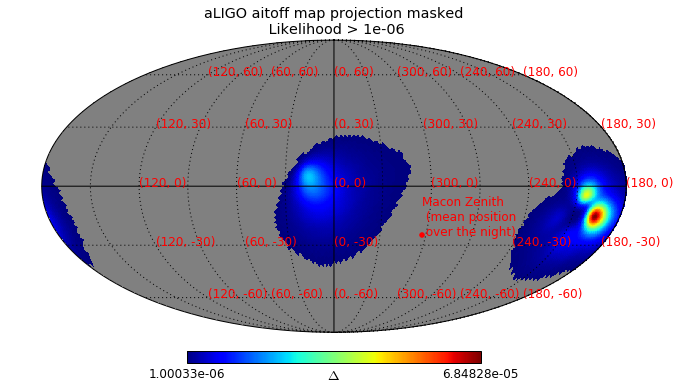

In [119]:
likehood_cut=0.000001 #ut level for mask buildup

aligo_alert_map_high_like=np.logical_not(aligo_banana < likehood_cut)
map_lik_masked=hp.ma(aligo_banana)
map_lik_masked.mask=np.logical_not(aligo_alert_map_high_like)

hp.mollview(map_lik_masked.filled(), 
            title='aLIGO aitoff map projection masked\n Likelihood > {}'.format(likehood_cut),
            unit='$\Delta$', fig=2)
hp.graticule()
hp.projscatter(mean_zenith_ra, zenith_dec
               , lonlat=True, color="red")
hp.projtext(mean_zenith_ra, zenith_dec,
            'Macon Zenith\n (mean position\n over the night)', lonlat=True, color="red")

for ra in range(0,360,60):
    for dec in range(-60,80,30):
        if not (ra == 300 and dec == -30):
            hp.projtext(ra,dec,'({}, {})'.format(ra,dec), lonlat=True, color='red')

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap_masked.png'), dpi=300)
plt.show()

In [105]:
import math
indy=0
deg2rad=math.pi/180.
indx = len(sample)
targetRA = np.zeros(indx)
targetDec = np.zeros(indx)
targetMag = np.zeros(indx)
target_a = np.zeros(indx)
target_b = np.zeros(indx)
name2 = []

targetLik= np.zeros(indx)
#totgal=0. tolerance if galactic cut is impossed due to confussion, measure it!
for row in sample:
    filename=row['PGC']
    #savefig("../plots/"+filename+".eps")
    rat=row['RA']*15.
    dect=row['Dec']
    #ipix = hp.ang2pix(NSIDE,theta,phi)  # be carefull its using mathematical coordinates hereafter
    theta= math.pi/2.-dect*deg2rad
    # colatitude in radians measured southward from north pole (in [0,$\pi$]). 
    phi= rat*deg2rad
    if phi <  0.: phi=phi+2.*pi 
    # longitude in radians measured eastward (in [0, $2\pi$])  
    if hp.pixelfunc.get_interp_val(aligo_alert_map_high_like,theta,phi,nest=False)  > 0.2:
        #the value of 0.2 is due to the averaging process on npix=4!     
        targetMag[indy]=row['App_Mag']
        targetRA[indy]=row['RA']
        targetDec[indy]= row['Dec']
        target_a[indy]=row['Maj_Diam_a']
        target_b[indy]=row['Min_Diam_b']
        name2.append(row['Name'])
        targetLik[indy]= hp.pixelfunc.get_interp_val(aligo_banana,theta,phi,nest=False) 
        # alternatively use masked Lik
        indy=indy+1 
    #hp.gnomview(aligo_alert_map_high_like,rot=[n.galactic.b.deg,n.galactic.l.deg], xsize=15, ysize=15, title=filename, unit='$\Delta$', fig=2)
    #hp.graticule()
    #plt.show()

In [138]:
import math
deg2rad = math.pi/180.

filenames = sample['PGC']
phis = [row['RA']*15.*deg2rad for row in sample]
thetas = math.pi/2. - sample['Dec']*deg2rad

804


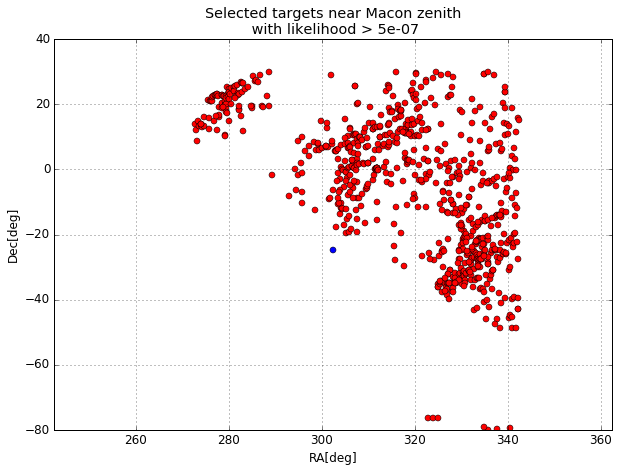

In [114]:
print indy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":12})
plt.plot(targetRA*15.,targetDec, "ro")
plt.plot(mean_zenith_ra, zenith_dec, 'bo')
plt.xlim(mean_zenith_ra-60, mean_zenith_ra+60)
plt.title("Selected targets near Macon zenith\n with likelihood > {}".format(likehood_cut))
plt.xlabel("RA[deg]")
plt.ylabel("Dec[deg]")
plt.grid()
plt.savefig(os.path.join(plots, "selected_targets_Ra_dec.png"), dpi=300)
plt.show()

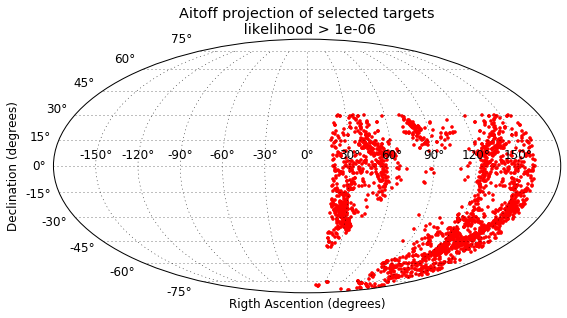

In [134]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="mollweide")
deg2rad=math.pi/180.
j=0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360,360)
for i in range(indy):
        x = np.remainder(targetRA[i]*15.+360,360) # shift RA values
        if x > 180.: 
            x = x-360. # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        xg[j]=x*deg2rad 
        yg[j]=(targetDec[i])*deg2rad
        #print gx[j], xg[j], yg[j]
        j=j+1
               
plt.plot(xg,yg, "r.")
plt.grid(True)
plt.xlabel("Rigth Ascention (degrees)")
plt.ylabel("Declination (degrees)")
plt.title("Aitoff projection of selected targets\n likelihood > {}".format(likehood_cut))
plt.savefig(os.path.join(plots,"aitoff_selected_targets.png"), dpi=300)
plt.show()

Uno puede ahora usar las galaxias (visibles) dentro de la mascara y rankearlas como mas le guste.
Se pueden ordenar simplemente por Likehood por ejemplo, ahora dado que van a estar observando varios
telescopios (quizas conviene acordar quien mira quien) y las mejoras de posteriores de las alertas
cambian el negocio substancialmente ademas del input de nuestras mediciones

In [128]:
print indy,len(targetLik), targetLik[indy-1], targetLik[indy],  targetLik[indy+1]

804 2433 1.22592439311e-06 0.0 0.0


In [ ]:
index_array=np.argsort(targetLik[0:indy])
#print index_array

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
print 'N       RAJ2000      DecJ2000      Likelihood    MagB   RAJ2015   DecJ2015    Name'
RAJ2015 = []
DecJ2015 = []
likelihood = []
RAJ2000 = []
DecJ2000= []
AppMag  = []
name3 = []
dist = []
RA = []
Dec = []
for i in range(indy):
    ind=index_array[indy-i-1]
    coord=SkyCoord(ra=targetRA[ind]*u.hourangle, dec=targetDec[ind]*u.degree, frame='icrs')
    precessed=coord.transform_to(FK5(equinox='J2015.7'))
    RAJ2015.append(precessed.to_string('hmsdms').split()[0])
    DecJ2015.append(precessed.to_string('hmsdms').split()[1])
    strcoord = coord.to_string('hmsdms')
    RA.append(strcoord.split()[0])
    Dec.append(strcoord.split()[1])
    RAJ2000.append(targetRA[ind])
    DecJ2000.append(targetDec[ind])
    AppMag.append(targetMag[ind])
    likelihood.append(targetLik[ind])
    name3.append(name2[ind])
    dist.append(Dist[ind])
    #print i, coord.to_string('hmsdms'), targetLik[ind], targetMag[ind], RAJ2015[i], DecJ2015[i], name2[ind]

In [ ]:
from astropy.table import Table
candidates = Table()
candidates.add_column(Table.Column(name3, name=('Name')))
candidates.add_column(Table.Column(RAJ2000, name=('RAJ2000')))
candidates.add_column(Table.Column(DecJ2000, name=('DecJ2000')))
candidates.add_column(Table.Column(likelihood, name=('Likelihood')))
candidates.add_column(Table.Column(AppMag, name=('Appmag')))
candidates.add_column(Table.Column(RA, name=('RA')))
candidates.add_column(Table.Column(Dec, name=('Dec')))
candidates.add_column(Table.Column(RAJ2015, name=('RAJ2015')))
candidates.add_column(Table.Column(DecJ2015, name=('DecJ2015')))
candidates.add_column(Table.Column(dist, name=('Distance')))

In [ ]:
candidates.sort(['RAJ2000','Likelihood'])

In [ ]:
candidates.write('candidates20151022_textable.csv', format='csv')

In [ ]:
southern = candidates['DecJ2000']<0

In [ ]:
southern_sources = candidates[southern]

In [ ]:
plt.hist(southern_sources['Appmag'])
plt.show()

In [ ]:
plt.hist(southern_sources['Distance'])
plt.show()

In [ ]:
far = southern_sources['Distance']>35.
far_away = southern_sources[far]

In [ ]:
plt.plot(far_away['RAJ2000'], far_away['DecJ2000'], 'bo')
plt.show()

In [ ]:
far_away.sort('Likelihood')

In [ ]:
plt.plot(far_away['RAJ2000'], far_away['Likelihood'], 'bo')
plt.xlabel('RA')
plt.ylabel('Likelihood')
for source in far_away:
    plt.Annotation(s=source['Name'], xy=(source['RAJ2000'], source['Likelihood']), xycoords='data')
#plt.Annotation(s='hola', xy=(5,0.001), xycoords='data')
plt.show()

In [ ]:
far_away.reverse()

In [ ]:
far_away

In [ ]:

plt.figure(figsize=(14,9))
plt.scatter(np.asarray(far_away['RAJ2000']), np.asarray(far_away['DecJ2000']), s=2E11*far_away['Likelihood']**2., 
            c=far_away['Likelihood'])
plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
a_hi = far_away['RAJ2000']<7.
a_lo = far_away['RAJ2000']>0.5
secbin= far_away[a_hi & a_lo]
lik = secbin['Likelihood']

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(np.asarray(secbin['RAJ2000']), np.asarray(secbin['DecJ2000']), s=2E11*secbin['Likelihood']**2., 
            c=secbin['Likelihood'])
for goodies in range(3):
    row = secbin[goodies]
    plt.annotate(s=str(row['Name']), xy=(row['RAJ2000'], row['DecJ2000']))

plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [ ]:
aaa = SkyCoord(ra=secbin[7]['RAJ2000']*u.hourangle, dec=secbin[7]['DecJ2000']*u.degree)
aaa.to_string('hmsdms')

In [ ]:
bbb = SkyCoord(ra=secbin[0]['RAJ2000']*u.hourangle, dec=secbin[0]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
b_hi = candidates['RAJ2000']<7.5
b_lo = candidates['RAJ2000']>5.5
dist_lo = candidates['Distance']>35.
mag_hi = candidates['Appmag']< 17.
thirdbin= candidates[b_hi & b_lo & mag_hi & dist_lo]
thirdbin.sort('Likelihood')

In [ ]:
bbb = SkyCoord(ra=thirdbin[1]['RAJ2000']*u.hourangle, dec=thirdbin[1]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

In [ ]:
thirdbin

In [ ]:
SkyCoord